In [1]:
# Importing necessary libraries
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Constants
s = 150  # Image size
THRESHOLD = 100  # Threshold for edge detection

In [3]:
# Function to preprocess image using Sobel edge detection
def preprocess_image(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert image to grayscale
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Sobel edge detection
    grad_x = cv2.filter2D(gray_img, -1, sobel_x)
    grad_y = cv2.filter2D(gray_img, -1, sobel_y)
    gradient_magnitude = np.sqrt(grad_x ** 2 + grad_y ** 2)
    
    # Thresholding
    edges = np.uint8(gradient_magnitude > THRESHOLD) * 255
    edges = cv2.resize(edges, (s, s))  # Resize to fixed size
    edges_flat = edges.flatten()

    return edges_flat


In [4]:
# Function to load and preprocess images
def load_and_preprocess_images(category_directory, class_label):
    dataset, labels = [], []
    
    for filename in os.listdir(category_directory):
        img = cv2.imread(os.path.join(category_directory, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0  # Normalize pixel values
            img = cv2.resize(img, (s, s))
            
            sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening
            img = cv2.filter2D(img, -1, sharpen_kernel)

            edges_flat = preprocess_image(img)  # Sobel edge detection
            img_flat = img.flatten()

            # Combine features
            features = np.hstack([img_flat, edges_flat])
            dataset.append(features)
            labels.append(class_label)

    return dataset, labels

In [5]:
# Dataset preparation
categories = ['/kaggle/input/human-diseases/DFU', '/kaggle/input/human-diseases/Mouth ULcerr']
labels = range(len(categories))
dataset, label = [], []

for category, label_id in zip(categories, labels):
    data, label_ids = load_and_preprocess_images(category, label_id)
    dataset.extend(data)
    label.extend(label_ids)


In [6]:
# Convert to numpy arrays and shuffle
dataset = np.array(dataset)
label = np.array(label)
dataset, label = shuffle(dataset, label, random_state=40)

In [7]:
# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.30, stratify=label, random_state=40)

In [8]:
# Initialize the MLP Classifier
mlp = MLPClassifier(max_iter=20, activation='relu', verbose=True, random_state=40)
mlp.fit(x_train, y_train)  # Train the classifier

# Make predictions
y_pred = mlp.predict(x_test)


Iteration 1, loss = 3.99999084
Iteration 2, loss = 4.92120654
Iteration 3, loss = 2.49118818
Iteration 4, loss = 1.79353171
Iteration 5, loss = 1.53893079
Iteration 6, loss = 1.36425418
Iteration 7, loss = 0.96785593
Iteration 8, loss = 0.87368903
Iteration 9, loss = 0.80230396
Iteration 10, loss = 0.68041848
Iteration 11, loss = 0.54921508
Iteration 12, loss = 0.46390453
Iteration 13, loss = 0.34134149
Iteration 14, loss = 0.27165953
Iteration 15, loss = 0.19537068
Iteration 16, loss = 0.19043983
Iteration 17, loss = 0.14991476
Iteration 18, loss = 0.13074660
Iteration 19, loss = 0.10180831
Iteration 20, loss = 0.09782121


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [9]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print evaluation metrics
print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)

Accuracy:  0.9592391304347826
F1 Score:  0.9591537743868941
Precision:  0.959203686200378
Recall:  0.9592391304347826


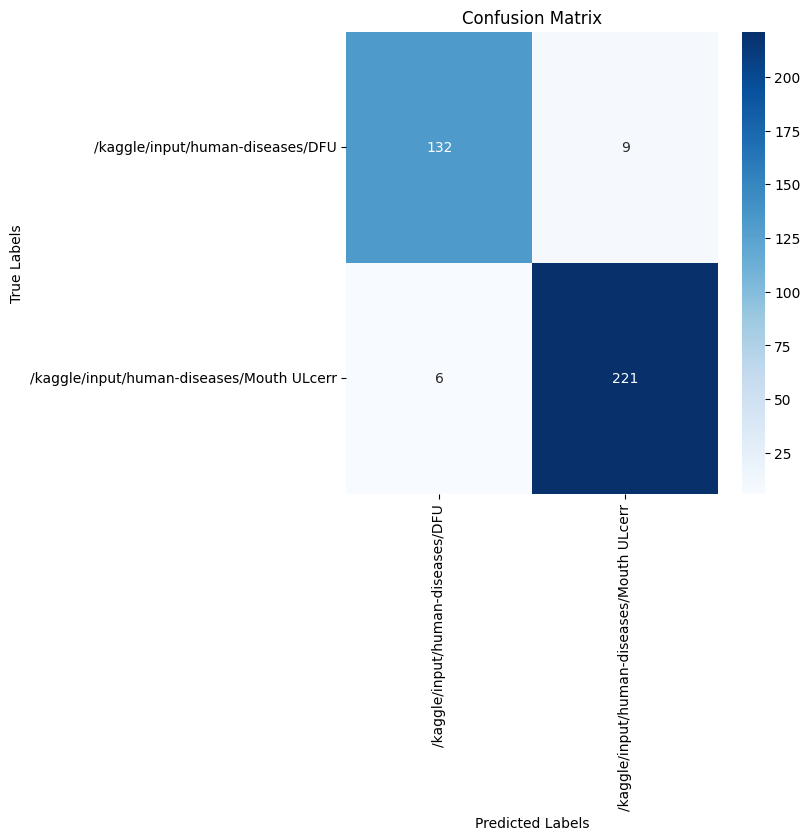

In [10]:
# Confusion Matrix and Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


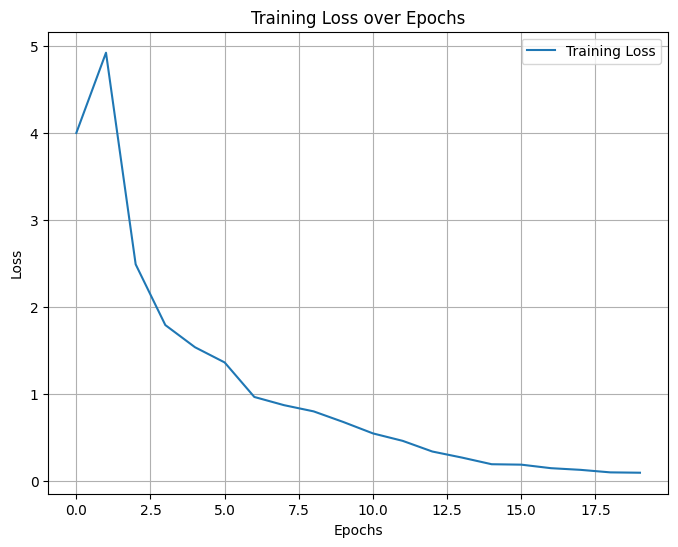

In [11]:
# Plot of training and validation accuracy over epochs
loss_values = mlp.loss_curve_
plt.figure(figsize=(8, 6))
plt.plot(loss_values, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()